# 無限時間最適フィードバック制御モデル
## モデルの構造
**無限時間最適フィードバック制御モデル** (**infinite-horizon optimal feedback control model**) {cite:p}`Qian2013-zy`

$$
\begin{align}
d x&=(\mathbf{A} x+\mathbf{B} u) dt +\mathbf{Y} u d \gamma+\mathbf{G} d \omega \\
d y&=\mathbf{C} x dt+\mathbf{D} d \xi\\
d \hat{x}&=(\mathbf{A} \hat{x}+\mathbf{B} u) dt+\mathbf{K}(dy-\mathbf{C} \hat{x} dt)
\end{align}
$$

## 実装
ライブラリの読み込みと関数の定義．

In [1]:
using Parameters: @unpack
using LinearAlgebra, Kronecker, Random, BlockDiagonals, PyPlot
rc("axes.spines", top=false, right=false)
rc("font", family="Arial") 

定数の定義

$$
\begin{align}
\alpha_{1}&=\frac{b}{t_{a} t_{e} I},\quad \alpha_{2}=\frac{1}{t_{a} t_{e}}+\left(\frac{1}{t_{a}}+\frac{1}{t_{e}}\right) \frac{b}{I} \\
\alpha_{3}&=\frac{b}{I}+\frac{1}{t_{a}}+\frac{1}{t_{e}},\quad b_{u}=\frac{1}{t_{a} t_{e} I}
\end{align}
$$

In [2]:
@kwdef struct SaccadeModelParameter
    n = 4 # number of dims
    i = 0.25 # kgm^2, 
    b = 0.2 # kgm^2/s
    ta = 0.03 # s
    te = 0.04 # s
    L0 = 0.35 # m

    bu = 1 / (ta * te * i)
    α1 = bu * b
    α2 = 1/(ta * te) + (1/ta + 1/te) * b/i
    α3 = b/i + 1/ta + 1/te

    A = [zeros(3) I(3); -[0, α1, α2, α3]']
    B = [zeros(3); bu]
    C = [I(3) zeros(3)]
    D = Diagonal([1e-3, 1e-2, 5e-2])

    Y = 0.02 * B
    G = 0.03 * I(n)

    Q = Diagonal([1.0, 0.01, 0, 0]) 
    R = 0#0.0001
    U = Diagonal([1.0, 0.1, 0.01, 0])
end

SaccadeModelParameter

$$
\begin{align}
\mathbf{X}:=\begin{bmatrix}
x \\
\tilde{x}
\end{bmatrix}, d \bar{\omega} :=\begin{bmatrix}
d \omega \\
d \xi
\end{bmatrix}, \bar{\mathbf{A}} :=\begin{bmatrix}
\mathbf{A}-\mathbf{B} \mathbf{L} & \mathbf{B} \mathbf{L} \\
\mathbf{0} & \mathbf{A}-\mathbf{K} \mathbf{C}
\end{bmatrix}\\
\bar{\mathbf{Y}} :=\begin{bmatrix}
-\mathbf{Y} \mathbf{L} & \mathbf{Y} \mathbf{L} \\
-\mathbf{Y} \mathbf{L} & \mathbf{Y} \mathbf{L}
\end{bmatrix}, \bar{G} :=\begin{bmatrix}
\mathbf{G} & \mathbf{0} \\
\mathbf{G} & -\mathbf{K} \mathbf{D}
\end{bmatrix}
\end{align}
$$

とする．元論文では$F, \bar{F}$が定義されていたが，$F=0$とするため，以後の式から削除した．

$$
\begin{align}
\mathbf{P} &:=\begin{bmatrix}
\mathbf{P}_{11} & \mathbf{P}_{12} \\
\mathbf{P}_{12} & \mathbf{P}_{22}
\end{bmatrix} = \mathbb{E}\left[\mathbf{X} \mathbf{X}^\top\right] \\
\mathbf{V} &:=\begin{bmatrix}
\mathbf{Q}+\mathbf{L}^\top R \mathbf{L} & -\mathbf{L}^\top R \mathbf{L} \\
-\mathbf{L}^\top R \mathbf{L} & \mathbf{L}^\top R \mathbf{L}+\mathbf{U}
\end{bmatrix}
\end{align}
$$

aaa
$$
\begin{align}
&K=\mathbf{P}_{22} \mathbf{C}^\top\left(\mathbf{D} \mathbf{D}^\top\right)^{-1} \\
&\mathbf{L}=\left(R+\mathbf{Y}^\top\left(\mathbf{S}_{11}+\mathbf{S}_{22}\right) \mathbf{Y}\right)^{-1} \mathbf{B}^\top \mathbf{S}_{11} \\
&\bar{\mathbf{A}}^\top \mathbf{S}+\mathbf{S} \bar{\mathbf{A}}+\bar{\mathbf{Y}}^\top \mathbf{S} \bar{\mathbf{Y}}+\mathbf{V}=0 \\
&\bar{\mathbf{A}} \mathbf{P}+\mathbf{P} \bar{\mathbf{A}}^\top+\bar{\mathbf{Y}} \mathbf{P} \bar{\mathbf{Y}}^\top+\bar{\mathbf{G}} \bar{\mathbf{G}}^\top=0
\end{align}
$$


$\mathbf{A} = (a_{ij})$ を $m \times n$ 行列，$\mathbf{B} = (b_{kl})$ を $p \times q$ 行列とすると、それらのクロネッカー積 $\mathbf{A} \otimes \mathbf{B}$ は

$$
\begin{equation}
\mathbf{A}\otimes \mathbf{B}={\begin{bmatrix}a_{11}\mathbf{B}&\cdots &a_{1n}\mathbf{B}\\\vdots &\ddots &\vdots \\a_{m1}\mathbf{B}&\cdots &a_{mn}\mathbf{B}\end{bmatrix}}
\end{equation}
$$

で与えられる $mp \times nq$ 区分行列である．

Roth's column lemma (vec-trick) 

$$
\begin{equation}
(\mathbf{B}^\top \otimes \mathbf{A})\text{vec}(\mathbf{X}) = \text{vec}(\mathbf{A}\mathbf{X}\mathbf{B})=\text{vec}(\mathbf{C})
\end{equation}
$$

によりこれを解くと，

$$
\begin{align}
\mathbf{S} &= -\text{vec}^{-1}\left(\left(\mathbf{I} \otimes \bar{\mathbf{A}}^\top + \bar{\mathbf{A}}^\top \otimes \mathbf{I} + \bar{\mathbf{Y}}^\top \otimes \bar{\mathbf{Y}}^\top\right)^{-1}\text{vec}(\mathbf{V})\right)\\
\mathbf{P} &= -\text{vec}^{-1}\left(\left(\mathbf{I} \otimes \bar{\mathbf{A}} + \bar{\mathbf{A}} \otimes \mathbf{I} + \bar{\mathbf{Y}} \otimes \bar{\mathbf{Y}}\right)^{-1}\text{vec}(\bar{\mathbf{G}}\bar{\mathbf{G}}^\top)\right)
\end{align}
$$

となる．ここで$\mathbf{I}=\mathbf{I}^\top$を用いた．

### K, L, S, Pの計算
K, L, S, Pの計算は次のようにする．
1. LとKをランダムに初期化
1. SとPを計算
1. LとKを更新
1. 収束するまで2と3を繰り返す．

収束スピードはかなり速い．

In [3]:
function infinite_horizon_ofc(param::SaccadeModelParameter, maxiter=1000, ϵ=1e-8)
    @unpack n, A, B, C, D, Y, G, Q, R, U = param
    
    # initialize
    L = rand(n)' # Feedback gains
    K = rand(n, 3) # Kalman gains
    I₂ₙ = I(2n)

    for _ in 1:maxiter
        Ā = [A-B*L B*L; zeros(size(A)) (A-K*C)]
        Ȳ = [-ones(2) ones(2)] ⊗ (Y*L) 
        Ḡ = [G zeros(size(K)); G (-K*D)]
        V = BlockDiagonal([Q, U]) + [1 -1; -1 1] ⊗ (L'* R * L)

        # update S, P
        S = -reshape((I₂ₙ ⊗ (Ā)' +  (Ā)' ⊗ I₂ₙ + (Ȳ)' ⊗ (Ȳ)') \ vec(V), (2n, 2n))
        P = -reshape((I₂ₙ ⊗ Ā +  Ā ⊗ I₂ₙ + Ȳ ⊗  Ȳ) \ vec(Ḡ * (Ḡ)'), (2n, 2n))

        # update K, L
        P₂₂ = P[n+1:2n, n+1:2n]
        S₁₁ = S[1:n, 1:n]
        S₂₂ = S[n+1:2n, n+1:2n]

        Kₜ₋₁ = copy(K)
        Lₜ₋₁ = copy(L)

        K = P₂₂ * C' / (D * D')
        L = (R + Y' * (S₁₁ + S₂₂) * Y) \ B' * S₁₁
        if sum(abs.(K - Kₜ₋₁)) < ϵ && sum(abs.(L - Lₜ₋₁)) < ϵ
            break
        end
    end
    return L, K
end

infinite_horizon_ofc (generic function with 3 methods)

In [4]:
param = SaccadeModelParameter()
L, K = infinite_horizon_ofc(param);

### シミュレーション
関数を書く．

In [5]:
function simulation(param::SaccadeModelParameter, L, K, dt=0.001, T=2.0, init_pos=-0.5; noisy=true)
    @unpack n, A, B, C, D, Y, G, Q, R, U = param
    nt = round(Int, T/dt)
    X = zeros(n, nt)
    u = zeros(nt)
    X[1, 1] = init_pos # m; initial position (target position is zero)

    if noisy
        sqrtdt = √dt
        X̂ = zeros(n, nt)
        X̂[1, 1] = X[1, 1]
        for t in 1:nt-1
            u[t] = -L * X̂[:, t]
            X[:, t+1] = X[:,t] + (A * X[:,t] + B * u[t]) * dt + sqrtdt * (Y * u[t] * randn() + G * randn(n))
            dy = C * X[:,t] * dt + D * sqrtdt * randn(n-1)
            X̂[:, t+1] = X̂[:,t] + (A * X̂[:,t] + B * u[t]) * dt + K * (dy - C * X̂[:,t] * dt)
        end
    else
        for t in 1:nt-1
            u[t] = -L * X[:, t]
            X[:, t+1] = X[:, t] + (A * X[:, t] + B * u[t]) * dt
        end
    end
    return X, u
end

simulation (generic function with 4 methods)

理想状況でのシミュレーション

In [6]:
dt = 1e-3
T = 1.0

1.0

In [7]:
Xa, ua = simulation(param, L, K, dt, T, noisy=false);

### ノイズを含むシミュレーション
ノイズを含む場合．

In [8]:
n = 4
nsim = 10
XSimAll = []
uSimAll = []
for i in 1:nsim
    XSim, u = simulation(param, L, K, dt, T, noisy=true);
    push!(XSimAll, XSim)
    push!(uSimAll, u)
end

結果の描画

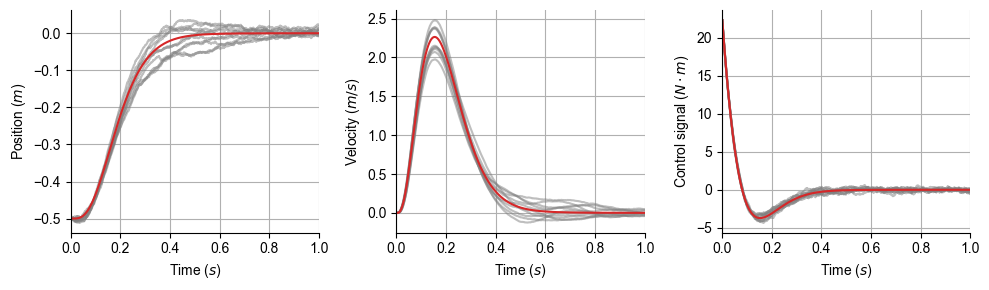

In [9]:
tarray = collect(dt:dt:T)
label = [L"Position ($m$)", L"Velocity ($m/s$)", L"Acceleration ($m/s^2$)", L"Jerk ($m/s^3$)"]

fig, ax = subplots(1, 3, figsize=(10, 3))
for i in 1:2
    for j in 1:nsim
        ax[i].plot(tarray, XSimAll[j][i,:]', "tab:gray", alpha=0.5)
    end
    
    ax[i].plot(tarray, Xa[i,:], "tab:red")
    ax[i].set_ylabel(label[i]); ax[i].set_xlabel(L"Time ($s$)"); ax[i].set_xlim(0, T); ax[i].grid()
end

for j in 1:nsim
    ax[3].plot(tarray, uSimAll[j], "tab:gray", alpha=0.5)
end
ax[3].plot(tarray, ua, "tab:red")
ax[3].set_ylabel(L"Control signal ($N\cdot m$)"); ax[3].set_xlabel(L"Time ($s$)"); ax[3].set_xlim(0, T); ax[3].grid()

tight_layout()

## Target jump

target jumpする場合の最適制御 {cite:p}`Li2018-qt`. 状態にtarget位置も含むモデルであればtarget位置をずらせばよいが，ここでは自己位置をずらしtargetとの相対位置を変化させることでtarget jumpを実現する．

In [10]:
function target_jump_simulation(param::SaccadeModelParameter, L, K, dt=0.001, T=2.0, 
        Ttj=0.4, tj_dist=0.1, 
        init_pos=-0.5; noisy=true)
    # Ttj : target jumping timing (sec)
    # tj_dist : target jump distance
    @unpack n, A, B, C, D, Y, G, Q, R, U = param
    nt = round(Int, T/dt)
    ntj = round(Int, Ttj/dt)
    X = zeros(n, nt)
    u = zeros(nt)
    X[1, 1] = init_pos # m; initial position (target position is zero)

    if noisy
        sqrtdt = √dt
        X̂ = zeros(n, nt)
        X̂[1, 1] = X[1, 1]
        for t in 1:nt-1
            if t == ntj
                X[1, t] -= tj_dist # When k == ntj, target jumpさせる（実際には現在の位置をずらす）
                X̂[1, t] -= tj_dist
            end
            u[t] = -L * X̂[:, t]
            X[:, t+1] = X[:,t] + (A * X[:,t] + B * u[t]) * dt + sqrtdt * (Y * u[t] * randn() + G * randn(n))
            dy = C * X[:,t] * dt + D * sqrtdt * randn(n-1)
            X̂[:, t+1] = X̂[:,t] + (A * X̂[:,t] + B * u[t]) * dt + K * (dy - C * X̂[:,t] * dt)
        end
    else
        for t in 1:nt-1
            if t == ntj
                X[1, t] -= tj_dist # When k == ntj, target jumpさせる（実際には現在の位置をずらす）
            end
            u[t] = -L * X[:, t]
            X[:, t+1] = X[:, t] + (A * X[:, t] + B * u[t]) * dt
        end
    end
    X[1, 1:ntj-1] .-= tj_dist;
    return X, u
end

target_jump_simulation (generic function with 6 methods)

In [11]:
Ttj = 0.4
tj_dist = 0.1
nt = round(Int, T/dt)
ntj = round(Int, Ttj/dt);

In [12]:
Xtj, utj = target_jump_simulation(param, L, K, dt, T, noisy=false);

In [13]:
XtjAll = []
utjAll = []
for i in 1:nsim
    XSim, u = target_jump_simulation(param, L, K, dt, T, noisy=true);
    push!(XtjAll, XSim)
    push!(utjAll, u)
end

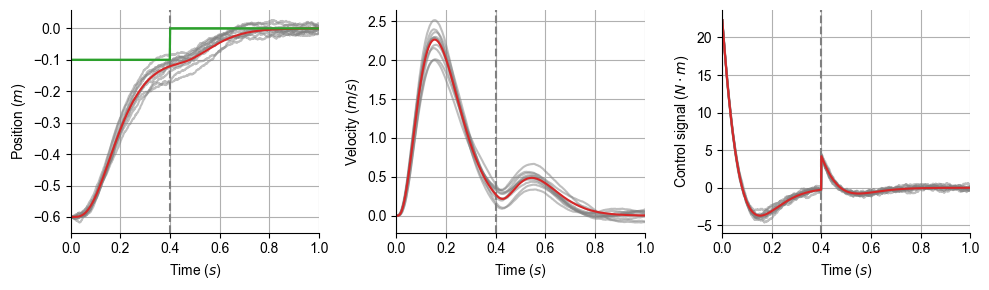

In [14]:
target_pos = zeros(nt)
target_pos[1:ntj-1] .-= tj_dist; 

fig, ax = subplots(1, 3, figsize=(10, 3))
for i in 1:2
    ax[1].plot(tarray, target_pos, "tab:green")
    for j in 1:nsim
        ax[i].plot(tarray, XtjAll[j][i,:]', "tab:gray", alpha=0.5)
    end
    ax[i].axvline(x=Ttj, color="gray", linestyle="dashed")
    ax[i].plot(tarray, Xtj[i,:], "tab:red")
    ax[i].set_ylabel(label[i]); ax[i].set_xlabel(L"Time ($s$)"); ax[i].set_xlim(0, T); ax[i].grid()
end
for j in 1:nsim
    ax[3].plot(tarray, utjAll[j], "tab:gray", alpha=0.5)
end
ax[3].axvline(x=Ttj, color="gray", linestyle="dashed")
ax[3].plot(tarray, utj, "tab:red")
ax[3].set_ylabel(L"Control signal ($N\cdot m$)"); ax[3].set_xlabel(L"Time ($s$)"); ax[3].set_xlim(0, T); ax[3].grid()

tight_layout()

## 参考文献
```{bibliography}
:filter: docname in docnames
```